In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import time
import random

In [6]:
class Transform(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        sample = np.array(sample, dtype = np.float32)
        sample = torch.tensor(sample)
        return (sample/127.5)-1

transform = Transform()

In [7]:
from tqdm import tqdm

class dataset_full(torch.utils.data.Dataset):

    def __init__(self, img, label, transform=None):
        self.transform = transform
        self.data_num = len(img)
        self.data = []
        self.label = []
        for i in tqdm(range(self.data_num)):
            self.data.append([img[i]])
            self.label.append(label[i])
        self.data_num = len(self.data)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = np.identity(49)[self.label[idx]]
        out_label = np.array(out_label, dtype = np.float32)

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [8]:
!ls data

k49-test-imgs.npz    k49-train-imgs.npz
k49-test-labels.npz  k49-train-labels.npz


In [8]:
"""
import zipfile

hiragana73_path = '../dataset/hira_gen/hiragana73.zip'
with zipfile.ZipFile(hiragana73_path) as existing_zip:
    existing_zip.extractall(hiragana73_path[:-4])
hiragana73s = os.listdir(hiragana73_path[:-4])
hiragana73_dirs = [f for f in hiragana73s if os.path.isdir(os.path.join(hiragana73_path[:-4], f))]
print(hiragana73_dirs) 

hiragana_imgs_path = '/content/drive/MyDrive/hira_gen/hiragana_imgs.zip'
with zipfile.ZipFile(hiragana_imgs_path) as existing_zip:
    existing_zip.extractall(hiragana_imgs_path[:-4])
hiragana_imgs = os.listdir(hiragana_imgs_path[:-4])
hiragana_img_dirs = [f for f in hiragana_imgs if os.path.isdir(os.path.join(hiragana_imgs_path[:-4], f))]
print(hiragana_img_dirs) 

# get label
# あーん
all_label_classes = set([os.path.basename(d) for d in hiragana73_dirs] + [os.path.basename(d) for d in hiragana_img_dirs])
# 0-
all_labels = [i for i in range(len(all_label_classes))]
print(all_label_classes)
print(len(all_label_classes))
print(all_labels)
"""

NameError: ignored

In [9]:
# create hiragana73 map dict
hiragana73_map = {}
with open('./hiragana_mojigazo_map.txt') as hm:
    lines = hm.readlines()
    for l in lines:
        map_line = l.strip().split(',')
        hiragana73_map[map_line[1]] = map_line[0]
print(hiragana73_map)
print(len(hiragana73_map))

{'U3042': 'あ', 'U3044': 'い', 'U3046': 'う', 'U3048': 'え', 'U304A': 'お', 'U304B': 'か', 'U304C': 'が', 'U304D': 'き', 'U304E': 'ぎ', 'U304F': 'く', 'U3050': 'ぐ', 'U3051': 'け', 'U3052': 'げ', 'U3053': 'こ', 'U3054': 'ご', 'U3055': 'さ', 'U3056': 'ざ', 'U3057': 'し', 'U3058': 'じ', 'U3059': 'す', 'U305A': 'ず', 'U305B': 'せ', 'U305C': 'ぜ', 'U305D': 'そ', 'U305E': 'ぞ', 'U305F': 'た', 'U3060': 'だ', 'U3061': 'ち', 'U3062': 'ぢ', 'U3064': 'つ', 'U3065': 'づ', 'U3066': 'て', 'U3067': 'で', 'U3068': 'と', 'U3069': 'ど', 'U306A': 'な', 'U306B': 'に', 'U306C': 'ぬ', 'U306D': 'ね', 'U306E': 'の', 'U306F': 'は', 'U3070': 'ば', 'U3071': 'ぱ', 'U3072': 'ひ', 'U3073': 'び', 'U3074': 'ぴ', 'U3075': 'ふ', 'U3076': 'ぶ', 'U3077': 'ぷ', 'U3078': 'へ', 'U3079': 'べ', 'U307A': 'ぺ', 'U307B': 'ほ', 'U307C': 'ぼ', 'U307D': 'ぽ', 'U307E': 'ま', 'U307F': 'み', 'U3080': 'む', 'U3081': 'め', 'U3082': 'も', 'U3084': 'や', 'U3086': 'ゆ', 'U3088': 'よ', 'U3089': 'ら', 'U308A': 'り', 'U308B': 'る', 'U308C': 'れ', 'U308D': 'ろ', 'U308F': 'わ', 'U3090': 'ゐ', 'U3091': 'ゑ', 'U309

In [24]:
'げ'=='げ'

True

In [26]:
basedir = '../dataset/hiragana73'
for fn in os.listdir(basedir):
    # print(fn)
    if not os.path.isdir(os.path.join(basedir, fn)):
        continue # Not a directory
    if fn in hiragana73_map.keys():
        newfn  = hiragana73_map[fn]
        # print(newfn)
        os.rename(os.path.join(basedir, fn), os.path.join(basedir, newfn))

In [27]:
hiragana73_path = '../dataset/hiragana73'

hiragana73s = os.listdir(hiragana73_path)
hiragana73_dirs = []
for f in hiragana73s:
    # print(f)
    if os.path.isdir(os.path.join(hiragana73_path, f)):
        hiragana73_dirs.append(f)
print(hiragana73_dirs)
print(len(hiragana73_dirs))

hiragana_imgs_path = '../dataset/hiragana_imgs'

hiragana_imgs = os.listdir(hiragana_imgs_path)
hiragana_img_dirs = [f for f in hiragana_imgs if os.path.isdir(os.path.join(hiragana_imgs_path, f))]
print(hiragana_img_dirs) 
print(len(hiragana_img_dirs))

# get label
# あーん
all_label_classes = list(set([os.path.basename(d) for d in hiragana73_dirs] + [os.path.basename(d) for d in hiragana_img_dirs]))
all_label_classes.sort()
# 0-
all_labels = [i for i in range(len(all_label_classes))]
print(all_label_classes)
print(len(all_label_classes))
print(all_labels)

['ぱ', 'え', 'た', 'つ', 'ぷ', 'げ', 'そ', 'ろ', 'だ', 'ぺ', 'り', 'ご', 'ぎ', 'ず', 'よ', 'ね', 'ば', 'ひ', 'ゑ', 'ま', 'や', 'め', 'ん', 'を', 'は', 'む', 'ほ', 'ぶ', 'ふ', 'び', 'と', 'の', 'う', 'て', 'ざ', 'が', 'へ', 'く', 'ぼ', 'ゐ', 'も', 'に', 'わ', 'べ', 'ぬ', 'じ', 'れ', 'ら', 'ぢ', 'す', 'づ', 'ぞ', 'ち', 'け', 'お', 'な', 'い', 'で', 'あ', 'ど', 'き', 'ぜ', 'ぐ', 'ぽ', 'さ', 'こ', 'か', 'せ', 'み', 'る', 'し', 'ゆ', 'ぴ']
73
['ゅ', 'ぱ', 'え', 'た', 'つ', 'ぷ', 'げ', 'そ', 'ろ', 'ゃ', 'だ', 'ぺ', 'り', 'ご', 'ぎ', 'ず', 'よ', 'ね', 'ば', 'ひ', 'ぃ', 'ゑ', 'ま', 'ぁ', 'や', 'め', 'ん', 'を', 'は', 'む', 'ほ', 'ぶ', 'ふ', 'ぉ', 'び', 'と', 'の', 'っ', 'う', 'て', 'ざ', 'が', 'へ', 'ぅ', 'く', 'ぼ', 'ゐ', 'も', 'に', 'わ', 'ゝ', 'べ', 'ぬ', 'ぇ', 'じ', 'れ', 'ら', 'ぢ', 'ょ', 'す', 'づ', 'ぞ', 'ち', 'け', 'お', 'な', 'い', 'で', 'あ', 'ど', 'き', 'ぜ', 'ゎ', 'ぐ', 'ぽ', 'さ', 'こ', 'か', 'せ', 'み', 'ゞ', 'る', 'し', 'ゆ', 'ぴ']
85
['ぁ', 'あ', 'ぃ', 'い', 'ぅ', 'う', 'ぇ', 'え', 'ぉ', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'っ', 'つ', 'づ', 'て', 'で', 'と', '

In [34]:
import glob

img_dicts = {}
label_dicts = {}
# key: あーん
# value: [all paths]
for cls, label in zip(all_label_classes, all_labels):
  img_dicts[cls] = []
  label_dicts[cls] = str(label)
  # hiragana73_path
  hiragana73_path_target_cls_dir = os.path.join(hiragana73_path, cls)
  if os.path.exists(hiragana73_path_target_cls_dir):
    hiragana73_cls_imgs = glob.glob(hiragana73_path_target_cls_dir + '/*')
  else:
    hiragana73_cls_imgs = []
  print(len(hiragana73_cls_imgs))

  # hiragana_imgs_path
  hiragana_imgs_path_target_cls_dir = os.path.join(hiragana_imgs_path, cls)
  if os.path.exists(hiragana_imgs_path_target_cls_dir):
    hiragana_imgs_path_cls_imgs = glob.glob(hiragana_imgs_path_target_cls_dir + '/*')
  else:
    hiragana_imgs_path_cls_imgs = []
  print(len(hiragana_imgs_path_cls_imgs))
  
  cls_imgs = hiragana73_cls_imgs + hiragana_imgs_path_cls_imgs
  print(len(cls_imgs))

  for cls_img_path in cls_imgs:
    img_dicts[cls].append(cls_img_path)
  print(cls)
  print(len(img_dicts[cls]))

print(label_dicts)

0
380
380
ぁ
380
1208
386
1594
あ
1594
0
380
380
ぃ
380
1122
386
1508
い
1508
0
380
380
ぅ
380
1148
386
1534
う
1534
0
380
380
ぇ
380
1077
386
1463
え
1463
0
380
380
ぉ
380
1283
386
1669
お
1669
1259
386
1645
か
1645
1200
384
1584
が
1584
1121
386
1507
き
1507
1091
384
1475
ぎ
1475
1266
386
1652
く
1652
1043
384
1427
ぐ
1427
1155
386
1541
け
1541
1058
384
1442
げ
1442
1115
391
1506
こ
1506
1078
384
1462
ご
1462
1261
386
1647
さ
1647
1070
379
1449
ざ
1449
1285
386
1671
し
1671
1099
379
1478
じ
1478
1282
386
1668
す
1668
1046
379
1425
ず
1425
1165
386
1551
せ
1551
1115
379
1494
ぜ
1494
1285
386
1671
そ
1671
1066
379
1445
ぞ
1445
1285
386
1671
た
1671
1116
379
1495
だ
1495
1052
386
1438
ち
1438
1132
379
1511
ぢ
1511
0
381
381
っ
381
1142
386
1528
つ
1528
1080
379
1459
づ
1459
1213
386
1599
て
1599
1178
379
1557
で
1557
1184
386
1570
と
1570
1134
379
1513
ど
1513
1233
386
1619
な
1619
1260
386
1646
に
1646
1093
386
1479
ぬ
1479
1126
386
1512
ね
1512
1160
386
1546
の
1546
1247
386
1633
は
1633
1105
379
1484
ば
1484
262
379
641
ぱ
641
1074

In [71]:
# create train paths and label
train_data = []

for hira, fps in img_dicts.items():
    label =int(label_dicts[hira])
    for fp in fps:
        train_data.append([fp, label])
train_data = np.array(train_data)
print(train_data.shape)
print(train_data)
np.random.shuffle(train_data)
train_data =  train_data.T
print(train_data)

(112570, 2)
[['../dataset/hiragana_imgs/ぁ/AP.jpg' '0']
 ['../dataset/hiragana_imgs/ぁ/ZinHenaKokuryu-RDF.jpg' '0']
 ['../dataset/hiragana_imgs/ぁ/851H-kktt_004.jpg' '0']
 ...
 ['../dataset/hiragana_imgs/ゞ/GenShinGothic-P-ExtraLight.jpg' '84']
 ['../dataset/hiragana_imgs/ゞ/GenEiMGothic2-Medium.jpg' '84']
 ['../dataset/hiragana_imgs/ゞ/GenEiGothicM-Bold.jpg' '84']]
[['../dataset/hiragana73/ひ/1901_824642_0005.png'
  '../dataset/hiragana_imgs/ゑ/M+A1_heavy-58-1.2.jpg'
  '../dataset/hiragana73/ら/1901_752792_0090.png' ...
  '../dataset/hiragana73/ぎ/1918_957654_0051.png'
  '../dataset/hiragana_imgs/ぅ/M+A1_medium-35-1.2.jpg'
  '../dataset/hiragana_imgs/わ/M+A1_medium-30-2.0.jpg']
 ['49' '80' '72' ... '13' '4' '78']]


In [73]:
train_img = []
for fp in train_data[0]:
    img = cv2.imread(fp)
    img = cv2.resize(img, (28, 28))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train_img.append(img)
train_img = np.array(train_img)
print(train_img.shape)
train_label = train_data[1].astype(np.uint8)
print(train_label)

(112570, 28, 28)
[49 80 72 ... 13  4 78]


In [55]:
"""
path = './data'
train_img = np.load('{}/k49-train-imgs.npz'.format(path))
train_img = train_img['arr_0']
train_label = np.load('{}/k49-train-labels.npz'.format(path))
train_label = train_label['arr_0']
"""

"\npath = './data'\ntrain_img = np.load('{}/k49-train-imgs.npz'.format(path))\ntrain_img = train_img['arr_0']\ntrain_label = np.load('{}/k49-train-labels.npz'.format(path))\ntrain_label = train_label['arr_0']\n"

In [56]:
train_img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [51]:
train_label

array([ 0,  0,  0, ..., 84, 84, 84], dtype=uint8)

In [ ]:
train_data = dataset_full(train_img, train_label, transform=transform)

In [ ]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=2)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_class):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(z_dim, 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.LReLU1 = nn.LeakyReLU(0.2)

        self.fc2 = nn.Linear(num_class, 1500)
        self.bn2 = nn.BatchNorm1d(1500)
        self.LReLU2 = nn.LeakyReLU(0.2)

        self.fc3 = nn.Linear(1800, 128 * 7 * 7)
        self.bn3 = nn.BatchNorm1d(128 * 7 * 7)
        self.bo1 = nn.Dropout(p=0.5)
        self.LReLU3 = nn.LeakyReLU(0.2)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), #チャネル数を128⇒64に変える。
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1), #チャネル数を64⇒1に変更
            nn.Tanh(),
        )

        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm1d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()

    def forward(self, noise, labels):
        y_1 = self.fc1(noise)
        y_1 = self.bn1(y_1)
        y_1 = self.LReLU1(y_1)

        y_2 = self.fc2(labels)
        y_2 = self.bn2(y_2)
        y_2 = self.LReLU2(y_2)

        x = torch.cat([y_1, y_2], 1)
        x = self.fc3(x)
        x = self.bo1(x)
        x = self.LReLU3(x)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_class):
        super(Discriminator, self).__init__()
        self.num_class = num_class

        self.conv = nn.Sequential(
            nn.Conv2d(num_class + 1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm1d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.normal_(1.0, 0.02)
                module.bias.data.zero_()

    def forward(self, img, labels):
        y_2 = labels.view(-1, self.num_class, 1, 1)
        y_2 = y_2.expand(-1, -1, 28, 28)

        x = torch.cat([img, y_2], 1)

        x = self.conv(x)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [ ]:
def train_func(D_model, G_model, batch_size, z_dim, num_class, criterion, 
               D_optimizer, G_optimizer, data_loader, device):
    #訓練モード
    D_model.train()
    G_model.train()

    #本物のラベルは1
    y_real = torch.ones((batch_size, 1)).to(device)
    D_y_real = (torch.rand((batch_size, 1))/2 + 0.7).to(device) #Dに入れるノイズラベル

    #偽物のラベルは0
    y_fake = torch.zeros((batch_size, 1)).to(device)
    D_y_fake = (torch.rand((batch_size, 1)) * 0.3).to(device) #Dに入れるノイズラベル

    #lossの初期化
    D_running_loss = 0
    G_running_loss = 0

    #バッチごとの計算
    for batch_idx, (data, labels) in enumerate(data_loader):
        #バッチサイズに満たない場合は無視
        if data.size()[0] != batch_size:
            break

        #ノイズ作成
        z = torch.normal(mean = 0.5, std = 0.2, size = (batch_size, z_dim)) #平均0.5の正規分布に従った乱数を生成

        real_img, label, z = data.to(device), labels.to(device), z.to(device)

        #Discriminatorの更新
        D_optimizer.zero_grad()

        #Discriminatorに本物画像を入れて順伝播⇒Loss計算
        D_real = D_model(real_img, label)
        D_real_loss = criterion(D_real, D_y_real)

        #DiscriminatorにGeneratorにノイズを入れて作った画像を入れて順伝播⇒Loss計算
        fake_img = G_model(z, label)
        D_fake = D_model(fake_img.detach(), label) #fake_imagesで計算したLossをGeneratorに逆伝播させないように止める
        D_fake_loss = criterion(D_fake, D_y_fake)

        #2つのLossの和を最小化
        D_loss = D_real_loss + D_fake_loss

        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()

        #Generatorの更新
        G_optimizer.zero_grad()

        #Generatorにノイズを入れて作った画像をDiscriminatorに入れて順伝播⇒見破られた分がLossになる
        fake_img_2 = G_model(z, label)
        D_fake_2 = D_model(fake_img_2, label)

        #Gのloss(max(log D)で最適化)
        G_loss = -criterion(D_fake_2, y_fake)

        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()

    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)

    return D_running_loss, G_running_loss

In [ ]:

import os
from IPython.display import Image
from torchvision.utils import save_image
%matplotlib inline

def Generate_img(epoch, G_model, device, z_dim, noise, var_mode, labels, log_dir='./logs_cGAN'):
    G_model.eval()

    with torch.no_grad():
        if var_mode == True:
            #生成に必要な乱数
            noise = torch.normal(mean = 0.5, std = 0.2, size = (49, z_dim)).to(device)
        else:
            noise = noise

        #Generatorでサンプル生成
        samples = G_model(noise, labels).data.cpu()
        samples = (samples/2)+0.5
        try:
          print(os.path.join(log_dir, 'epoch_%05d.png'))
          print(os.path.exists(log_dir))
          save_image(samples,os.path.join(log_dir, 'epoch_%05d.png' % (epoch)), nrow = 7)
        except:
          import pdb;pdb.set_trace()
        img = Image('./logs_cGAN/epoch_%05d.png' % (epoch))
        display(img)

Epoch: 1  | 所要時間 2 分 20 秒
	Loss: 1.2398(Discriminator)
	Loss: -0.6539(Generator)
./logs_cGAN/epoch_%05d.png
True


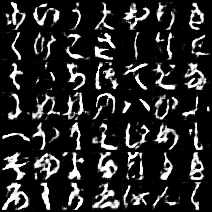

Epoch: 2  | 所要時間 2 分 19 秒
	Loss: 1.1752(Discriminator)
	Loss: -0.5999(Generator)
./logs_cGAN/epoch_%05d.png
True


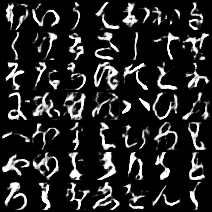

Epoch: 3  | 所要時間 2 分 19 秒
	Loss: 1.1421(Discriminator)
	Loss: -0.5797(Generator)
./logs_cGAN/epoch_%05d.png
True


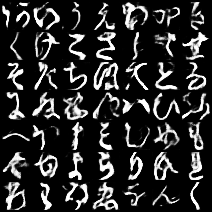

Epoch: 4  | 所要時間 2 分 19 秒
	Loss: 1.0580(Discriminator)
	Loss: -0.5466(Generator)
./logs_cGAN/epoch_%05d.png
True


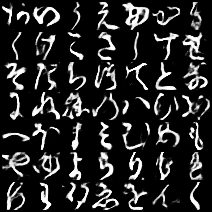

Epoch: 5  | 所要時間 2 分 20 秒
	Loss: 0.9961(Discriminator)
	Loss: -0.4493(Generator)
./logs_cGAN/epoch_%05d.png
True


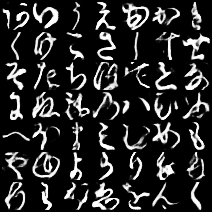

Epoch: 6  | 所要時間 2 分 19 秒
	Loss: 0.8922(Discriminator)
	Loss: -0.3963(Generator)
./logs_cGAN/epoch_%05d.png
True


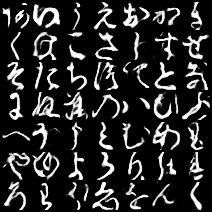

Epoch: 7  | 所要時間 2 分 20 秒
	Loss: 0.8366(Discriminator)
	Loss: -0.3529(Generator)
./logs_cGAN/epoch_%05d.png
True


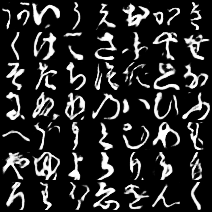

Epoch: 8  | 所要時間 2 分 19 秒
	Loss: 0.7615(Discriminator)
	Loss: -0.3088(Generator)
./logs_cGAN/epoch_%05d.png
True


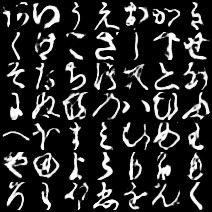

Epoch: 9  | 所要時間 2 分 20 秒
	Loss: 0.7840(Discriminator)
	Loss: -0.2512(Generator)
./logs_cGAN/epoch_%05d.png
True


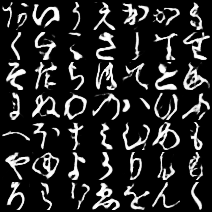

Epoch: 10  | 所要時間 2 分 19 秒
	Loss: 0.7471(Discriminator)
	Loss: -0.2518(Generator)
./logs_cGAN/epoch_%05d.png
True


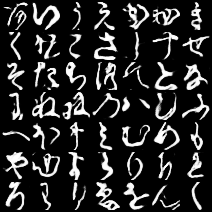

Epoch: 11  | 所要時間 2 分 20 秒
	Loss: 0.7670(Discriminator)
	Loss: -0.2363(Generator)
./logs_cGAN/epoch_%05d.png
True


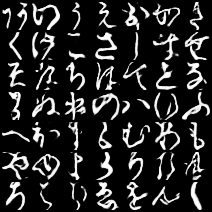

Epoch: 12  | 所要時間 2 分 20 秒
	Loss: 0.7533(Discriminator)
	Loss: -0.2454(Generator)
./logs_cGAN/epoch_%05d.png
True


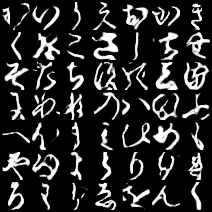

Epoch: 13  | 所要時間 2 分 20 秒
	Loss: 0.7216(Discriminator)
	Loss: -0.2196(Generator)
./logs_cGAN/epoch_%05d.png
True


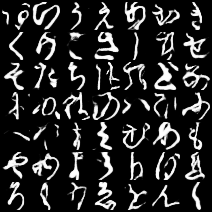

Epoch: 14  | 所要時間 2 分 20 秒
	Loss: 0.7353(Discriminator)
	Loss: -0.2192(Generator)
./logs_cGAN/epoch_%05d.png
True


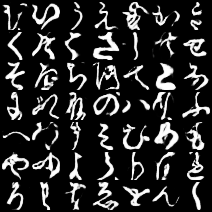

Epoch: 15  | 所要時間 2 分 20 秒
	Loss: 0.7471(Discriminator)
	Loss: -0.2180(Generator)
./logs_cGAN/epoch_%05d.png
True


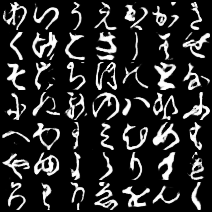

Epoch: 16  | 所要時間 2 分 19 秒
	Loss: 0.6827(Discriminator)
	Loss: -0.2160(Generator)
./logs_cGAN/epoch_%05d.png
True


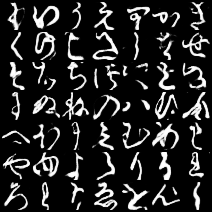

Epoch: 17  | 所要時間 2 分 20 秒
	Loss: 0.6875(Discriminator)
	Loss: -0.2184(Generator)
./logs_cGAN/epoch_%05d.png
True


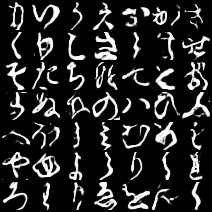

Epoch: 18  | 所要時間 2 分 19 秒
	Loss: 0.7208(Discriminator)
	Loss: -0.2131(Generator)
./logs_cGAN/epoch_%05d.png
True


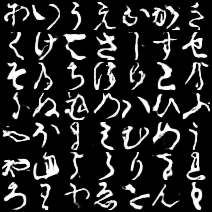

Epoch: 19  | 所要時間 2 分 20 秒
	Loss: 0.6954(Discriminator)
	Loss: -0.2088(Generator)
./logs_cGAN/epoch_%05d.png
True


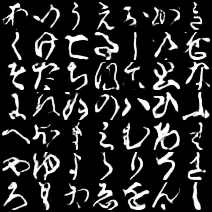

Epoch: 20  | 所要時間 2 分 19 秒
	Loss: 0.7324(Discriminator)
	Loss: -0.2103(Generator)
./logs_cGAN/epoch_%05d.png
True


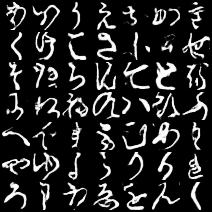

Epoch: 21  | 所要時間 2 分 20 秒
	Loss: 0.7303(Discriminator)
	Loss: -0.2166(Generator)
./logs_cGAN/epoch_%05d.png
True


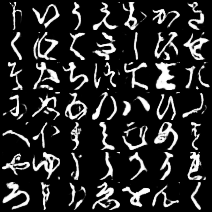

Epoch: 22  | 所要時間 2 分 19 秒
	Loss: 0.7002(Discriminator)
	Loss: -0.2215(Generator)
./logs_cGAN/epoch_%05d.png
True


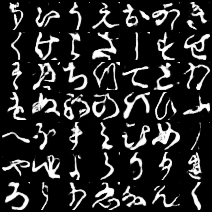

Epoch: 23  | 所要時間 2 分 20 秒
	Loss: 0.6929(Discriminator)
	Loss: -0.1955(Generator)
./logs_cGAN/epoch_%05d.png
True


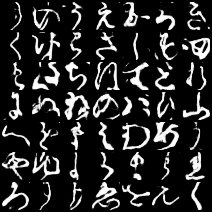

Epoch: 24  | 所要時間 2 分 19 秒
	Loss: 0.7041(Discriminator)
	Loss: -0.2031(Generator)
./logs_cGAN/epoch_%05d.png
True


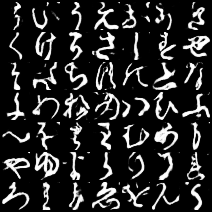

Epoch: 25  | 所要時間 2 分 20 秒
	Loss: 0.7068(Discriminator)
	Loss: -0.2052(Generator)
./logs_cGAN/epoch_%05d.png
True


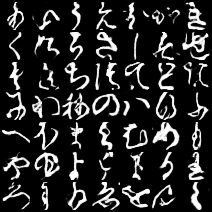

Epoch: 26  | 所要時間 2 分 20 秒
	Loss: 0.7302(Discriminator)
	Loss: -0.1931(Generator)
./logs_cGAN/epoch_%05d.png
True


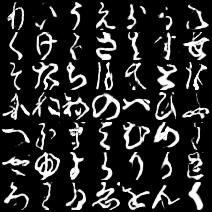

Epoch: 27  | 所要時間 2 分 20 秒
	Loss: 0.6883(Discriminator)
	Loss: -0.2005(Generator)
./logs_cGAN/epoch_%05d.png
True


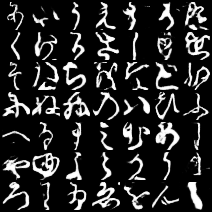

Epoch: 28  | 所要時間 2 分 19 秒
	Loss: 0.6916(Discriminator)
	Loss: -0.1934(Generator)
./logs_cGAN/epoch_%05d.png
True


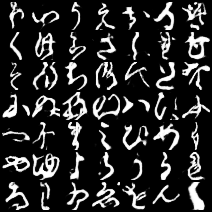

Epoch: 29  | 所要時間 2 分 20 秒
	Loss: 0.6630(Discriminator)
	Loss: -0.1897(Generator)
./logs_cGAN/epoch_%05d.png
True


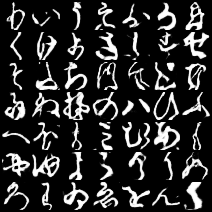

Epoch: 30  | 所要時間 2 分 19 秒
	Loss: 0.7040(Discriminator)
	Loss: -0.1839(Generator)
./logs_cGAN/epoch_%05d.png
True


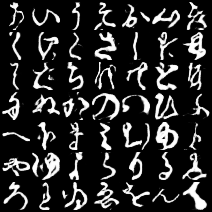

Epoch: 31  | 所要時間 2 分 20 秒
	Loss: 0.6786(Discriminator)
	Loss: -0.2047(Generator)
./logs_cGAN/epoch_%05d.png
True


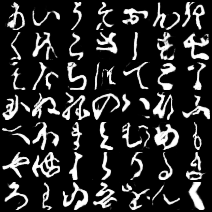

Epoch: 32  | 所要時間 2 分 19 秒
	Loss: 0.7146(Discriminator)
	Loss: -0.1980(Generator)
./logs_cGAN/epoch_%05d.png
True


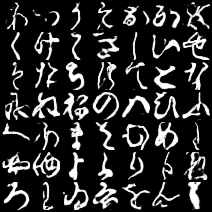

Epoch: 33  | 所要時間 2 分 20 秒
	Loss: 0.7407(Discriminator)
	Loss: -0.1938(Generator)
./logs_cGAN/epoch_%05d.png
True


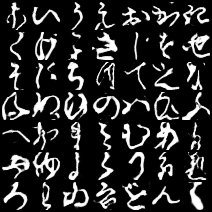

Epoch: 34  | 所要時間 2 分 19 秒
	Loss: 0.6914(Discriminator)
	Loss: -0.1917(Generator)
./logs_cGAN/epoch_%05d.png
True


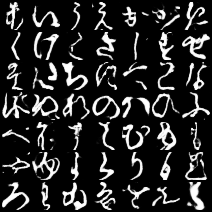

Epoch: 35  | 所要時間 2 分 20 秒
	Loss: 0.6405(Discriminator)
	Loss: -0.1963(Generator)
./logs_cGAN/epoch_%05d.png
True


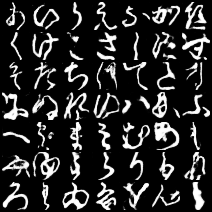

Epoch: 36  | 所要時間 2 分 19 秒
	Loss: 0.6803(Discriminator)
	Loss: -0.2023(Generator)
./logs_cGAN/epoch_%05d.png
True


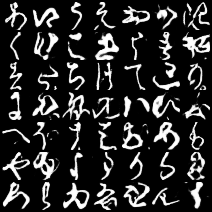

Epoch: 37  | 所要時間 2 分 20 秒
	Loss: 0.7039(Discriminator)
	Loss: -0.1964(Generator)
./logs_cGAN/epoch_%05d.png
True


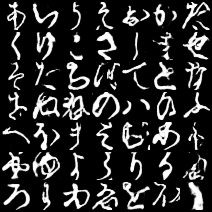

Epoch: 38  | 所要時間 2 分 19 秒
	Loss: 0.7222(Discriminator)
	Loss: -0.1984(Generator)
./logs_cGAN/epoch_%05d.png
True


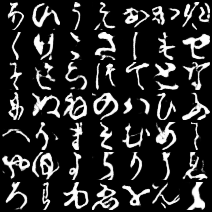

Epoch: 39  | 所要時間 2 分 20 秒
	Loss: 0.6925(Discriminator)
	Loss: -0.1974(Generator)
./logs_cGAN/epoch_%05d.png
True


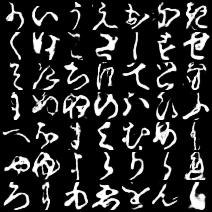

Epoch: 40  | 所要時間 2 分 19 秒
	Loss: 0.7204(Discriminator)
	Loss: -0.1949(Generator)
./logs_cGAN/epoch_%05d.png
True


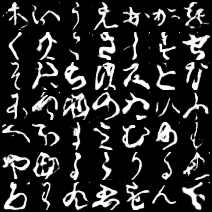

Epoch: 41  | 所要時間 2 分 20 秒
	Loss: 0.7251(Discriminator)
	Loss: -0.1910(Generator)
./logs_cGAN/epoch_%05d.png
True


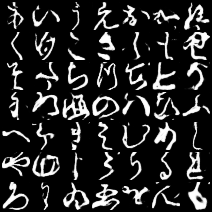

Epoch: 42  | 所要時間 2 分 19 秒
	Loss: 0.6878(Discriminator)
	Loss: -0.1855(Generator)
./logs_cGAN/epoch_%05d.png
True


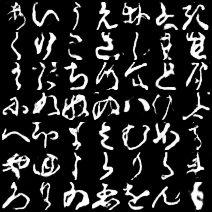

Epoch: 43  | 所要時間 2 分 20 秒
	Loss: 0.7181(Discriminator)
	Loss: -0.1909(Generator)
./logs_cGAN/epoch_%05d.png
True


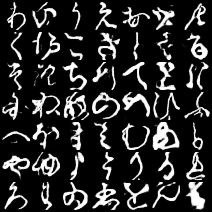

Epoch: 44  | 所要時間 2 分 19 秒
	Loss: 0.7006(Discriminator)
	Loss: -0.1905(Generator)
./logs_cGAN/epoch_%05d.png
True


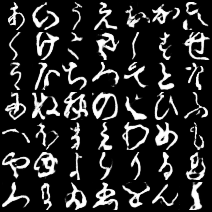

Epoch: 45  | 所要時間 2 分 20 秒
	Loss: 0.7257(Discriminator)
	Loss: -0.1957(Generator)
./logs_cGAN/epoch_%05d.png
True


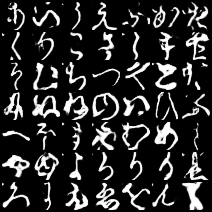

Epoch: 46  | 所要時間 2 分 19 秒
	Loss: 0.6982(Discriminator)
	Loss: -0.1802(Generator)
./logs_cGAN/epoch_%05d.png
True


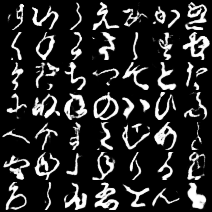

Epoch: 47  | 所要時間 2 分 20 秒
	Loss: 0.6804(Discriminator)
	Loss: -0.2019(Generator)
./logs_cGAN/epoch_%05d.png
True


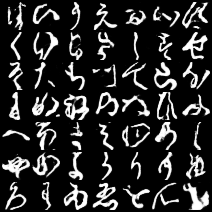

Epoch: 48  | 所要時間 2 分 20 秒
	Loss: 0.6866(Discriminator)
	Loss: -0.1886(Generator)
./logs_cGAN/epoch_%05d.png
True


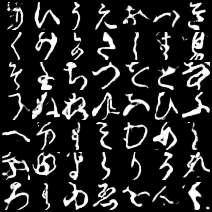

Epoch: 49  | 所要時間 2 分 20 秒
	Loss: 0.6483(Discriminator)
	Loss: -0.1771(Generator)
./logs_cGAN/epoch_%05d.png
True


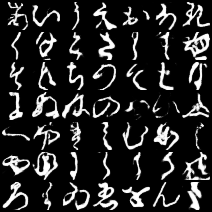

Epoch: 50  | 所要時間 2 分 19 秒
	Loss: 0.7070(Discriminator)
	Loss: -0.1936(Generator)
./logs_cGAN/epoch_%05d.png
True


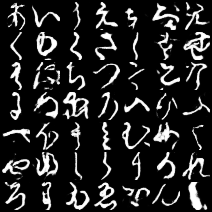

Epoch: 51  | 所要時間 2 分 20 秒
	Loss: 0.6954(Discriminator)
	Loss: -0.1786(Generator)
./logs_cGAN/epoch_%05d.png
True


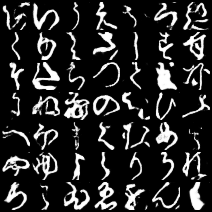

Epoch: 52  | 所要時間 2 分 19 秒
	Loss: 0.7288(Discriminator)
	Loss: -0.1950(Generator)
./logs_cGAN/epoch_%05d.png
True


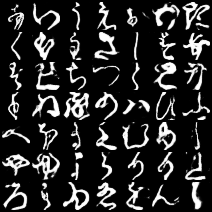

Epoch: 53  | 所要時間 2 分 20 秒
	Loss: 0.7036(Discriminator)
	Loss: -0.1917(Generator)
./logs_cGAN/epoch_%05d.png
True


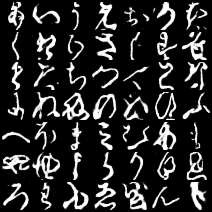

Epoch: 54  | 所要時間 2 分 19 秒
	Loss: 0.6777(Discriminator)
	Loss: -0.1860(Generator)
./logs_cGAN/epoch_%05d.png
True


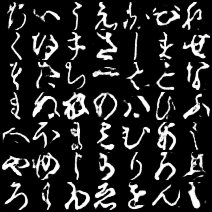

Epoch: 55  | 所要時間 2 分 20 秒
	Loss: 0.6665(Discriminator)
	Loss: -0.1856(Generator)
./logs_cGAN/epoch_%05d.png
True


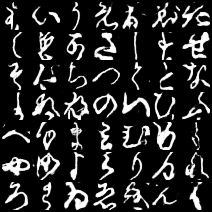

Epoch: 56  | 所要時間 2 分 19 秒
	Loss: 0.6925(Discriminator)
	Loss: -0.1752(Generator)
./logs_cGAN/epoch_%05d.png
True


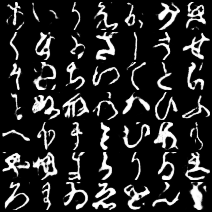

Epoch: 57  | 所要時間 2 分 20 秒
	Loss: 0.6623(Discriminator)
	Loss: -0.1777(Generator)
./logs_cGAN/epoch_%05d.png
True


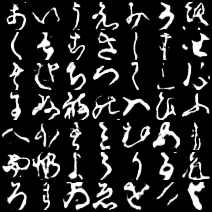

Epoch: 58  | 所要時間 2 分 19 秒
	Loss: 0.6641(Discriminator)
	Loss: -0.1864(Generator)
./logs_cGAN/epoch_%05d.png
True


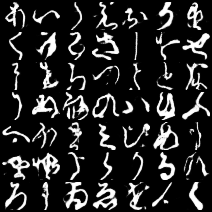

Epoch: 59  | 所要時間 2 分 19 秒
	Loss: 0.6889(Discriminator)
	Loss: -0.1835(Generator)
./logs_cGAN/epoch_%05d.png
True


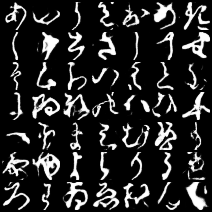

Epoch: 60  | 所要時間 2 分 19 秒
	Loss: 0.6336(Discriminator)
	Loss: -0.1736(Generator)
./logs_cGAN/epoch_%05d.png
True


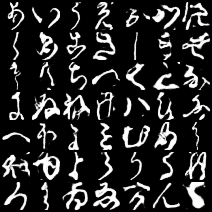

Epoch: 61  | 所要時間 2 分 19 秒
	Loss: 0.6865(Discriminator)
	Loss: -0.1922(Generator)
./logs_cGAN/epoch_%05d.png
True


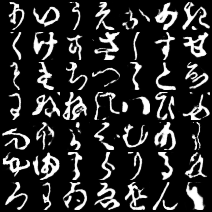

Epoch: 62  | 所要時間 2 分 19 秒
	Loss: 0.6801(Discriminator)
	Loss: -0.1982(Generator)
./logs_cGAN/epoch_%05d.png
True


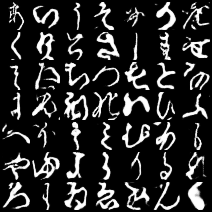

Epoch: 63  | 所要時間 2 分 19 秒
	Loss: 0.6966(Discriminator)
	Loss: -0.1785(Generator)
./logs_cGAN/epoch_%05d.png
True


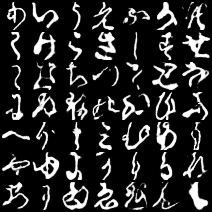

Epoch: 64  | 所要時間 2 分 19 秒
	Loss: 0.7137(Discriminator)
	Loss: -0.1863(Generator)
./logs_cGAN/epoch_%05d.png
True


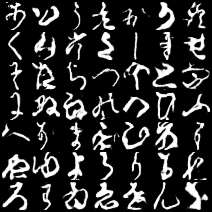

Epoch: 65  | 所要時間 2 分 20 秒
	Loss: 0.6829(Discriminator)
	Loss: -0.1733(Generator)
./logs_cGAN/epoch_%05d.png
True


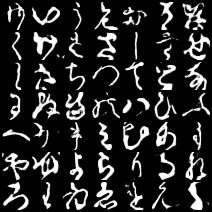

Epoch: 66  | 所要時間 2 分 19 秒
	Loss: 0.7116(Discriminator)
	Loss: -0.1866(Generator)
./logs_cGAN/epoch_%05d.png
True


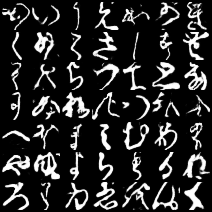

Epoch: 67  | 所要時間 2 分 20 秒
	Loss: 0.7140(Discriminator)
	Loss: -0.1874(Generator)
./logs_cGAN/epoch_%05d.png
True


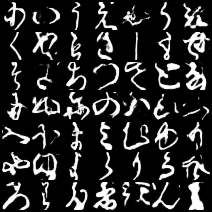

Epoch: 68  | 所要時間 2 分 19 秒
	Loss: 0.7161(Discriminator)
	Loss: -0.1887(Generator)
./logs_cGAN/epoch_%05d.png
True


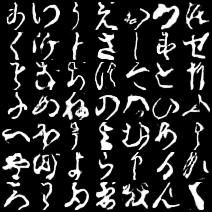

Epoch: 69  | 所要時間 2 分 20 秒
	Loss: 0.6809(Discriminator)
	Loss: -0.1929(Generator)
./logs_cGAN/epoch_%05d.png
True


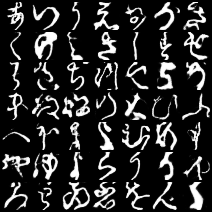

Epoch: 70  | 所要時間 2 分 19 秒
	Loss: 0.6644(Discriminator)
	Loss: -0.1897(Generator)
./logs_cGAN/epoch_%05d.png
True


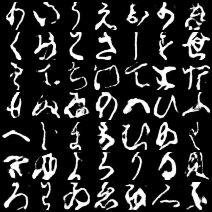

Epoch: 71  | 所要時間 2 分 20 秒
	Loss: 0.6677(Discriminator)
	Loss: -0.1828(Generator)
./logs_cGAN/epoch_%05d.png
True


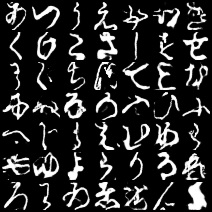

Epoch: 72  | 所要時間 2 分 20 秒
	Loss: 0.6247(Discriminator)
	Loss: -0.1750(Generator)
./logs_cGAN/epoch_%05d.png
True


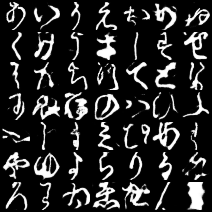

Epoch: 73  | 所要時間 2 分 20 秒
	Loss: 0.6706(Discriminator)
	Loss: -0.1947(Generator)
./logs_cGAN/epoch_%05d.png
True


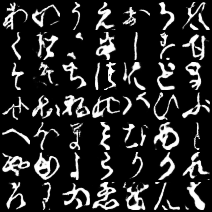

Epoch: 74  | 所要時間 2 分 19 秒
	Loss: 0.6535(Discriminator)
	Loss: -0.1778(Generator)
./logs_cGAN/epoch_%05d.png
True


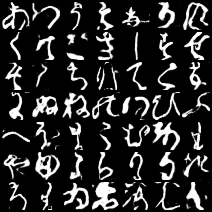

Epoch: 75  | 所要時間 2 分 19 秒
	Loss: 0.6774(Discriminator)
	Loss: -0.1889(Generator)
./logs_cGAN/epoch_%05d.png
True


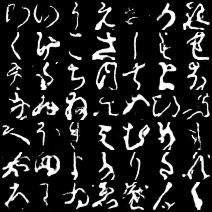

Epoch: 76  | 所要時間 2 分 18 秒
	Loss: 0.6973(Discriminator)
	Loss: -0.1872(Generator)
./logs_cGAN/epoch_%05d.png
True


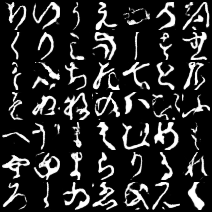

Epoch: 77  | 所要時間 2 分 19 秒
	Loss: 0.6376(Discriminator)
	Loss: -0.1822(Generator)
./logs_cGAN/epoch_%05d.png
True


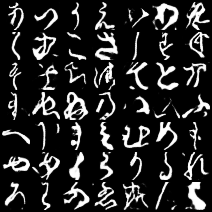

Epoch: 78  | 所要時間 2 分 18 秒
	Loss: 0.7449(Discriminator)
	Loss: -0.1860(Generator)
./logs_cGAN/epoch_%05d.png
True


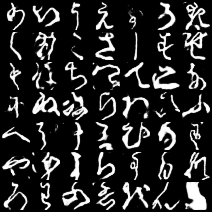

Epoch: 79  | 所要時間 2 分 19 秒
	Loss: 0.6771(Discriminator)
	Loss: -0.1879(Generator)
./logs_cGAN/epoch_%05d.png
True


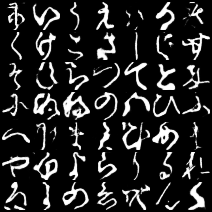

Epoch: 80  | 所要時間 2 分 18 秒
	Loss: 0.6710(Discriminator)
	Loss: -0.1761(Generator)
./logs_cGAN/epoch_%05d.png
True


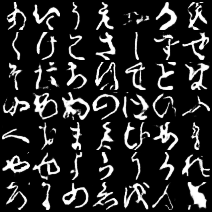

Epoch: 81  | 所要時間 2 分 18 秒
	Loss: 0.6431(Discriminator)
	Loss: -0.1896(Generator)
./logs_cGAN/epoch_%05d.png
True


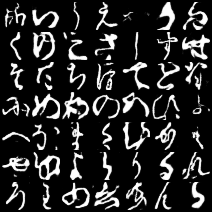

Epoch: 82  | 所要時間 2 分 18 秒
	Loss: 0.7016(Discriminator)
	Loss: -0.1865(Generator)
./logs_cGAN/epoch_%05d.png
True


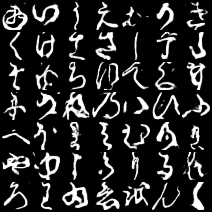

Epoch: 83  | 所要時間 2 分 18 秒
	Loss: 0.6760(Discriminator)
	Loss: -0.1823(Generator)
./logs_cGAN/epoch_%05d.png
True


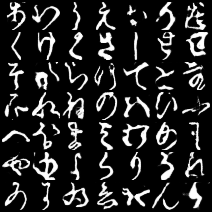

Epoch: 84  | 所要時間 2 分 18 秒
	Loss: 0.6722(Discriminator)
	Loss: -0.1696(Generator)
./logs_cGAN/epoch_%05d.png
True


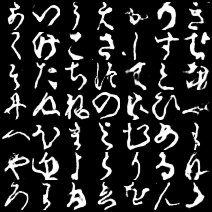

Epoch: 85  | 所要時間 2 分 18 秒
	Loss: 0.6485(Discriminator)
	Loss: -0.1795(Generator)
./logs_cGAN/epoch_%05d.png
True


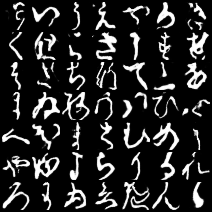

Epoch: 86  | 所要時間 2 分 18 秒
	Loss: 0.6531(Discriminator)
	Loss: -0.1875(Generator)
./logs_cGAN/epoch_%05d.png
True


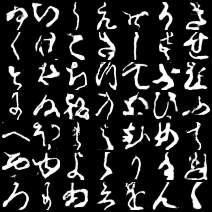

Epoch: 87  | 所要時間 2 分 18 秒
	Loss: 0.6493(Discriminator)
	Loss: -0.1749(Generator)
./logs_cGAN/epoch_%05d.png
True


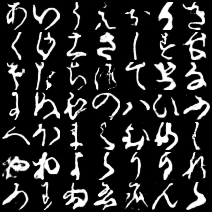

Epoch: 88  | 所要時間 2 分 18 秒
	Loss: 0.6984(Discriminator)
	Loss: -0.1758(Generator)
./logs_cGAN/epoch_%05d.png
True


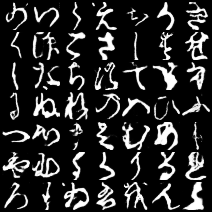

Epoch: 89  | 所要時間 2 分 18 秒
	Loss: 0.6919(Discriminator)
	Loss: -0.1895(Generator)
./logs_cGAN/epoch_%05d.png
True


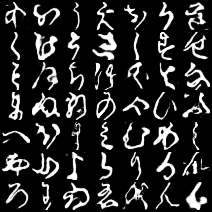

Epoch: 90  | 所要時間 2 分 18 秒
	Loss: 0.6667(Discriminator)
	Loss: -0.1833(Generator)
./logs_cGAN/epoch_%05d.png
True


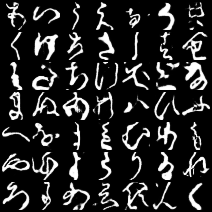

Epoch: 91  | 所要時間 2 分 19 秒
	Loss: 0.6889(Discriminator)
	Loss: -0.1774(Generator)
./logs_cGAN/epoch_%05d.png
True


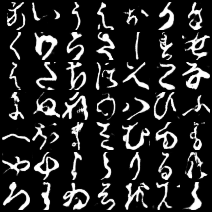

Epoch: 92  | 所要時間 2 分 18 秒
	Loss: 0.6652(Discriminator)
	Loss: -0.1707(Generator)
./logs_cGAN/epoch_%05d.png
True


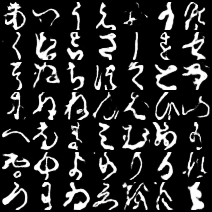

Epoch: 93  | 所要時間 2 分 18 秒
	Loss: 0.6502(Discriminator)
	Loss: -0.1780(Generator)
./logs_cGAN/epoch_%05d.png
True


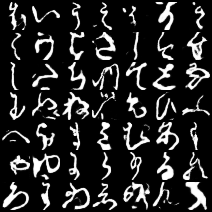

Epoch: 94  | 所要時間 2 分 18 秒
	Loss: 0.6652(Discriminator)
	Loss: -0.1597(Generator)
./logs_cGAN/epoch_%05d.png
True


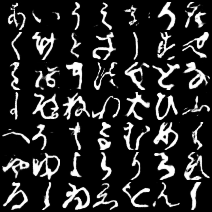

Epoch: 95  | 所要時間 2 分 19 秒
	Loss: 0.6820(Discriminator)
	Loss: -0.1734(Generator)
./logs_cGAN/epoch_%05d.png
True


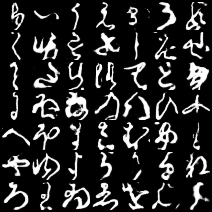

Epoch: 96  | 所要時間 2 分 18 秒
	Loss: 0.6901(Discriminator)
	Loss: -0.1760(Generator)
./logs_cGAN/epoch_%05d.png
True


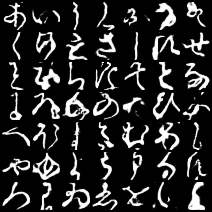

Epoch: 97  | 所要時間 2 分 19 秒
	Loss: 0.7145(Discriminator)
	Loss: -0.1817(Generator)
./logs_cGAN/epoch_%05d.png
True


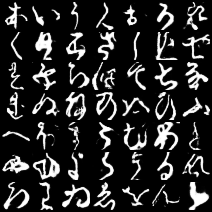

Epoch: 98  | 所要時間 2 分 18 秒
	Loss: 0.6900(Discriminator)
	Loss: -0.1800(Generator)
./logs_cGAN/epoch_%05d.png
True


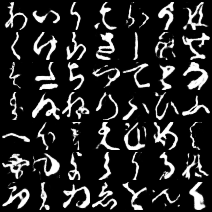

Epoch: 99  | 所要時間 2 分 18 秒
	Loss: 0.6383(Discriminator)
	Loss: -0.1711(Generator)
./logs_cGAN/epoch_%05d.png
True


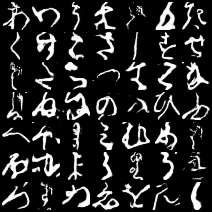

Epoch: 100  | 所要時間 2 分 18 秒
	Loss: 0.6531(Discriminator)
	Loss: -0.1723(Generator)
./logs_cGAN/epoch_%05d.png
True


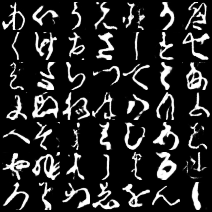

In [ ]:

#再現性確保のためseed値固定
SEED = 1111
random.seed(SEED)
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def model_run(num_epochs, batch_size = batch_size, dataloader = train_loader, device = device):

    #Generatorに入れるノイズの次元
    z_dim = 30
    var_mode = False #表示結果を見るときに毎回異なる乱数を使うかどうか
    #生成に必要な乱数
    noise = torch.normal(mean = 0.5, std = 0.2, size = (49, z_dim)).to(device)

    #クラス数
    num_class = 49

    #Generatorを試すときに使うラベルを作る
    labels = []
    for i in range(num_class):
        tmp = np.identity(num_class)[i]
        tmp = np.array(tmp, dtype = np.float32)
        labels.append(tmp)
    label = torch.Tensor(labels).to(device)

    #モデル定義
    D_model = Discriminator(num_class).to(device)
    G_model = Generator(z_dim, num_class).to(device)

    #lossの定義(引数はtrain_funcの中で指定)
    criterion = nn.BCELoss().to(device)

    #optimizerの定義
    D_optimizer = torch.optim.Adam(D_model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
    G_optimizer = torch.optim.Adam(G_model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)

    D_loss_list = []
    G_loss_list = []

    all_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()

        D_loss, G_loss = train_func(D_model, G_model, batch_size, z_dim, num_class, criterion, 
                                    D_optimizer, G_optimizer, dataloader, device)

        D_loss_list.append(D_loss)
        G_loss_list.append(G_loss)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        #エポックごとに結果を表示
        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {D_loss:.4f}(Discriminator)')
        print(f'\tLoss: {G_loss:.4f}(Generator)')

        if (epoch + 1) % 1 == 0:
            Generate_img(epoch, G_model, device, z_dim, noise, var_mode, label)

        #モデル保存のためのcheckpointファイルを作成
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch':epoch,
                'model_state_dict':G_model.state_dict(),
                'optimizer_state_dict':G_optimizer.state_dict(),
                'loss':G_loss,
            }, './checkpoint_cGAN/G_model_{}'.format(epoch + 1))

    return D_loss_list, G_loss_list

#モデルを回す
D_loss_list, G_loss_list = model_run(num_epochs = 100)

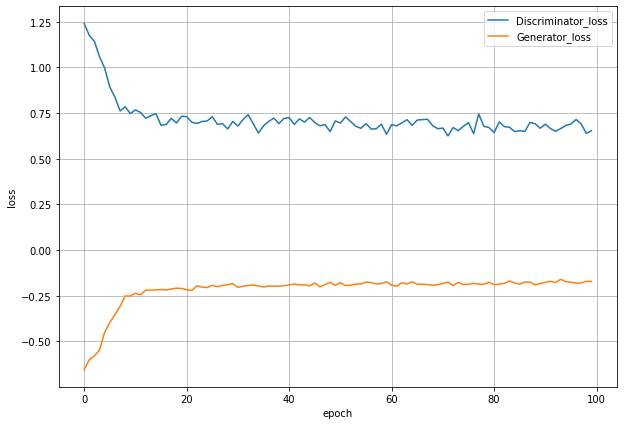

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(D_loss_list)),D_loss_list,label='Discriminator_loss')
loss.plot(range(len(G_loss_list)),G_loss_list,label='Generator_loss')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')

loss.legend()
loss.grid()

fig.show()